In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, Dataset
import torch
import spacy
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import os

## LOAD DATASET

In [ ]:
#set up nlp environment
nlp = spacy.load('en_core_web_sm')

#clone fewrel repository
!git clone https://github.com/thunlp/FewRel
#change directory
%cd FewRel

Cloning into 'FewRel'...
remote: Enumerating objects: 565, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 565 (delta 1), reused 0 (delta 0), pack-reused 559
Receiving objects: 100% (565/565), 24.68 MiB | 9.53 MiB/s, done.
Resolving deltas: 100% (340/340), done.
/content/FewRel


In [ ]:
#load training data
with open('./data/train_wiki.json', 'r') as file:
    data = json.load(file)

#load relation explanation
with open('./data/pid2name.json', 'r') as file:
    pid2name = json.load(file)

## UNDERSTANDING THE DATASET

In [ ]:
# Extract unique relation IDs
unique_relation_ids = set(data.keys())
num_unique_relation_ids = len(unique_relation_ids)

print(unique_relation_ids)
print(num_unique_relation_ids)

{'P800', 'P710', 'P276', 'P17', 'P140', 'P175', 'P137', 'P150', 'P1411', 'P105', 'P27', 'P57', 'P1923', 'P1303', 'P674', 'P58', 'P135', 'P159', 'P460', 'P355', 'P750', 'P4552', 'P1435', 'P241', 'P156', 'P176', 'P740', 'P6', 'P123', 'P527', 'P3373', 'P495', 'P466', 'P1346', 'P84', 'P407', 'P449', 'P706', 'P1001', 'P136', 'P86', 'P131', 'P991', 'P118', 'P306', 'P31', 'P551', 'P106', 'P1344', 'P101', 'P3450', 'P39', 'P403', 'P1877', 'P931', 'P178', 'P102', 'P127', 'P974', 'P264', 'P22', 'P400', 'P1408', 'P937'}
64


In [ ]:
# Print the structure of the dataset
print(f"Dataset type: {type(data)}")
if isinstance(data, dict):
    print(f"Number of relations: {len(data)}")
    first_key = list(data.keys())[0]
    print(f"Example relation ID: {first_key}")
    print(f"Number of instances for the first relation: {len(data[first_key])}")
    print(f"First instance of the first relation: {data[first_key][0]}")

Dataset type: <class 'dict'>
Number of relations: 64
Example relation ID: P931
Number of instances for the first relation: 700
First instance of the first relation: {'tokens': ['Merpati', 'flight', '106', 'departed', 'Jakarta', '(', 'CGK', ')', 'on', 'a', 'domestic', 'flight', 'to', 'Tanjung', 'Pandan', '(', 'TJQ', ')', '.'], 'h': ['tjq', 'Q1331049', [[16]]], 't': ['tanjung pandan', 'Q3056359', [[13, 14]]]}


Relation instance counts:
P931: 700
P4552: 700
P140: 700
P1923: 700
P150: 700
P6: 700
P27: 700
P449: 700
P1435: 700
P175: 700
P1344: 700
P39: 700
P527: 700
P740: 700
P706: 700
P84: 700
P495: 700
P123: 700
P57: 700
P22: 700
P178: 700
P241: 700
P403: 700
P1411: 700
P135: 700
P991: 700
P156: 700
P176: 700
P31: 700
P1877: 700
P102: 700
P1408: 700
P159: 700
P3373: 700
P1303: 700
P17: 700
P106: 700
P551: 700
P937: 700
P355: 700
P710: 700
P137: 700
P674: 700
P466: 700
P136: 700
P306: 700
P127: 700
P400: 700
P974: 700
P1346: 700
P460: 700
P86: 700
P118: 700
P264: 700
P750: 700
P58: 700
P3450: 700
P105: 700
P276: 700
P101: 700
P407: 700
P1001: 700
P800: 700
P131: 700


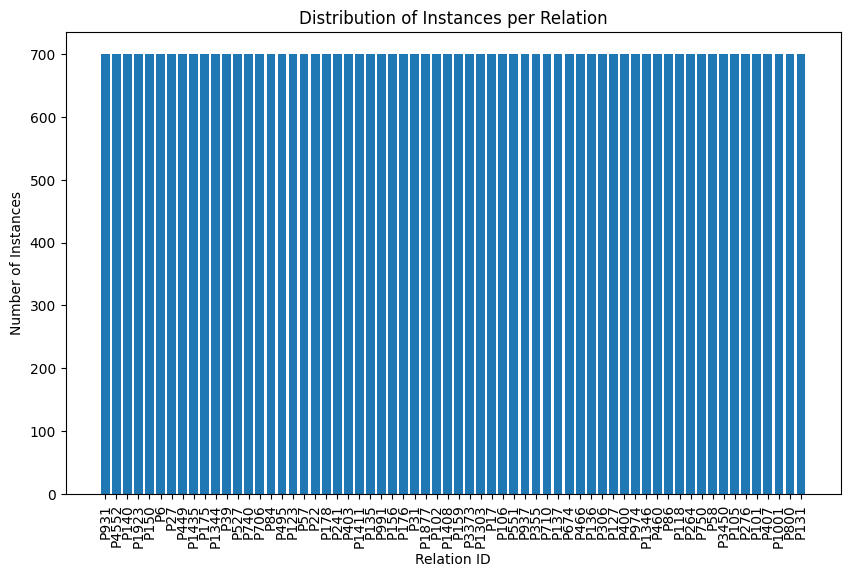

In [ ]:
relation_counts = {key: len(value) for key, value in data.items()}
print("Relation instance counts:")
for relation, count in relation_counts.items():
    print(f"{relation}: {count}")

# Plotting the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(relation_counts.keys(), relation_counts.values())
plt.xlabel('Relation ID')
plt.ylabel('Number of Instances')
plt.title('Distribution of Instances per Relation')
plt.xticks(rotation=90)
plt.show()


Average text length: 131.82734375


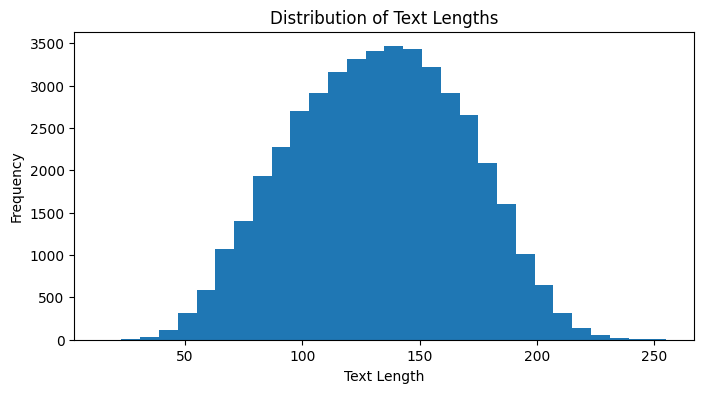

In [ ]:
text_lengths = []
for relation, instances in data.items():
    for instance in instances:
        text_lengths.append(len(" ".join(instance['tokens'])))

print(f"Average text length: {sum(text_lengths) / len(text_lengths)}")
plt.figure(figsize=(8, 4))
plt.hist(text_lengths, bins=30)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()


# INITIAL MODEL

## Training

In [ ]:
# Flatten the dataset and include the relation ID in each item
flattened_data = []
for relation_id, items in data.items():
    for item in items:
        item['relation_id'] = relation_id
        flattened_data.append(item)

# Prepare labels for stratification
strat_labels = [item['relation_id'] for item in flattened_data]

# Split the flattened dataset
train_data, validation_data = train_test_split(flattened_data, test_size=0.2, random_state=42, stratify=strat_labels)

# Mapping relation IDs to numeric labels
unique_relation_ids = set(data.keys())
relation_to_id = {relation: idx for idx, relation in enumerate(unique_relation_ids)}

# Custom Dataset Class and Custom Collate
class RelationExtractionDataset(Dataset):
    def __init__(self, tokenizer, data, relation_to_id, max_length=128): # Capped to 128 instead of 131 since Sequence lengths that are powers of 2 can sometimes help in optimizing memory allocation in certain hardwares
        self.tokenizer = tokenizer
        self.data = data
        self.relation_to_id = relation_to_id
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        sentence = " ".join(item['tokens'])
        label_id = self.relation_to_id[item['relation_id']]  # Use the added 'relation_id'
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='longest',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label_id, dtype=torch.long)
        }

def custom_collate_fn(batch):
    input_ids = pad_sequence([item['input_ids'] for item in batch], batch_first=True, padding_value=0)
    attention_mask = pad_sequence([item['attention_mask'] for item in batch], batch_first=True, padding_value=0)
    labels = torch.stack([item['labels'] for item in batch])

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

# Tokenizer and model initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(relation_to_id))

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize datasets and dataloaders
train_dataset = RelationExtractionDataset(tokenizer, train_data, relation_to_id)
validation_dataset = RelationExtractionDataset(tokenizer, validation_data, relation_to_id)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Prepare optimizer and schedule (linear warm-up and decay)
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 4

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=total_steps * 0.1, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch+1} | Average training loss: {total_loss / len(train_dataloader)}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 | Average training loss: 2.224142433357026
Epoch 2 | Average training loss: 1.0203836420550942
Epoch 3 | Average training loss: 0.6729124161115448
Epoch 4 | Average training loss: 0.45835835796814145


upon initial testing, the training loss from Epoch 3 to Epoch 4 is less significant than the previous ones, so no additional Epoch is needed

## Validation and Evaluation

### Checking gap between training vs validation performance

In [ ]:
def compute_metrics(predictions, true_labels):
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    return {"precision": precision, "recall": recall, "f1": f1}

def evaluate(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits

            batch_predictions = torch.argmax(logits, dim=1).detach().cpu().numpy()
            batch_labels = batch['labels'].detach().cpu().numpy()

            predictions.extend(batch_predictions)
            true_labels.extend(batch_labels)

    return compute_metrics(predictions, true_labels)

# Evaluate on training data
train_metrics = evaluate(model, train_dataloader, device)

# Evaluate on validation data
validation_metrics = evaluate(model, validation_dataloader, device)

# Print comparison
print("Training Metrics:")
print(f"Precision: {train_metrics['precision']}, Recall: {train_metrics['recall']}, F1: {train_metrics['f1']}")

print("\nValidation Metrics:")
print(f"Precision: {validation_metrics['precision']}, Recall: {validation_metrics['recall']}, F1: {validation_metrics['f1']}")


Training Metrics:
Precision: 0.9474771874578074, Recall: 0.9463764942261632, F1: 0.9457413894121589

Validation Metrics:
Precision: 0.6784123054391721, Recall: 0.6832782644484677, F1: 0.6790390487601456


### Checking performance per label

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluate mode
    model.to(device)  # Ensure the model is on the correct device

    predictions, true_labels = [], []

    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = batch['labels'].to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Calculate the accuracy for this batch of test sentences
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    pred_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_labels.flatten()

    return accuracy_score(labels_flat, pred_flat), classification_report(labels_flat, pred_flat)

# Evaluate the model
accuracy, report = evaluate_model(model, validation_dataloader)
print(f"Validation Accuracy: {accuracy}")
print(report)


Validation Accuracy: 0.6853794642857143
              precision    recall  f1-score   support

           0       0.49      0.50      0.49       145
           1       0.65      0.67      0.66       134
           2       0.68      0.75      0.72       126
           3       0.51      0.50      0.51       150
           4       0.97      0.98      0.97       150
           5       0.51      0.50      0.51       139
           6       0.77      0.68      0.72       152
           7       0.69      0.77      0.73       136
           8       0.84      0.95      0.89       136
           9       0.35      0.34      0.35       135
          10       0.58      0.75      0.65       130
          11       0.52      0.55      0.54       145
          12       0.72      0.76      0.74       148
          13       0.75      0.77      0.76       142
          14       0.70      0.73      0.71       150
          15       0.81      0.74      0.77       133
          16       0.99      0.99      0.

# IMPROVED MODEL

## Training

In [ ]:
# Flatten the dataset and include the relation ID in each item
flattened_data = []
for relation_id, items in data.items():
    for item in items:
        item_copy = item.copy()  # Create a copy of the dictionary to avoid modifying the original data
        item_copy['relation_id'] = relation_id
        flattened_data.append(item_copy)

# Prepare labels for stratification
strat_labels = [item['relation_id'] for item in flattened_data]

# Split the flattened dataset
train_data, validation_data = train_test_split(flattened_data, test_size=0.2, random_state=42, stratify=strat_labels)

# Mapping relation IDs to numeric labels
unique_relation_ids = set(data.keys())
relation_to_id = {relation: idx for idx, relation in enumerate(unique_relation_ids)}

# Custom Dataset Class
class RelationExtractionDataset(Dataset):
    def __init__(self, tokenizer, data, relation_to_id, max_length=128):
        self.tokenizer = tokenizer
        self.data = data
        self.relation_to_id = relation_to_id
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Get the tokens
        tokens = item['tokens']

        # Prepare to insert special tokens for head and tail entities
        head_positions = item['h'][2]
        tail_positions = item['t'][2]

        # Sort positions in reverse order to avoid altering indices of unprocessed tokens
        head_positions = sorted([pos for sublist in head_positions for pos in sublist], reverse=True)
        tail_positions = sorted([pos for sublist in tail_positions for pos in sublist], reverse=True)

        # Insert special tokens for head entity
        for pos in head_positions:
            tokens.insert(pos + 1, '[/E1]')
            tokens.insert(pos, '[E1]')

        # Insert special tokens for tail entity
        for pos in tail_positions:
            tokens.insert(pos + 1, '[/E2]')
            tokens.insert(pos, '[E2]')

        # Join the tokens into a single string
        sentence = " ".join(tokens)

        # Get the relation label ID
        label_id = self.relation_to_id[item['relation_id']]

        # Tokenize and create attention masks
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        # Return the input IDs, attention masks, and label as tensors
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label_id, dtype=torch.long)
        }


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer.add_tokens(['[E1]', '[/E1]', '[E2]', '[/E2]'])

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(relation_to_id))
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_dataset = RelationExtractionDataset(tokenizer, train_data, relation_to_id)
validation_dataset = RelationExtractionDataset(tokenizer, validation_data, relation_to_id)

# Setting dataloaders (batch size reduced from 4 to 2)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=2, shuffle=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Prepare optimizer and schedule (linear warm-up and decay)
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8, weight_decay=0.01)
epochs = 4

# Calculate the total number of training steps as the number of batches times the number of epochs
total_steps = len(train_dataloader) * epochs

# Create a linear scheduler with warm-up for the learning rate, starting with 10% of total steps as warm-up
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=total_steps * 0.1, num_training_steps=total_steps)

# Begin training loop over the specified number of epochs
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0  # Initialize total loss for the epoch
    for batch in train_dataloader:  # Iterate over batches of data in the train dataloader
        optimizer.zero_grad()  # Clear previous gradients
        input_ids = batch['input_ids'].to(device)  # Move input IDs to the device
        attention_mask = batch['attention_mask'].to(device)  # Move attention mask to the device
        labels = batch['labels'].to(device)  # Move labels to the device
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)  # Forward pass
        loss = outputs.loss  # Extract the loss from model outputs
        loss.backward()  # Backward pass to calculate gradients
        optimizer.step()  # Update model parameters
        scheduler.step()  # Update learning rate schedule
        total_loss += loss.item()  # Accumulate the loss

    # Print average training loss for the epoch
    print(f"Epoch {epoch+1} | Average training loss: {total_loss / len(train_dataloader)}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 | Average training loss: 1.532327004886247
Epoch 2 | Average training loss: 0.5048756376669254
Epoch 3 | Average training loss: 0.28484596879652274
Epoch 4 | Average training loss: 0.14702699140837744


### Saving the model

In [ ]:
# Save the fine-tuned model
model.save_pretrained('/content/drive/MyDrive/_COURSES_/TM/masking_bert')

In [ ]:
tokenizer.save_pretrained('/content/drive/MyDrive/_COURSES_/TM/masking_bert')

('/content/drive/MyDrive/_COURSES_/TM/masking_bert/tokenizer_config.json',
 '/content/drive/MyDrive/_COURSES_/TM/masking_bert/special_tokens_map.json',
 '/content/drive/MyDrive/_COURSES_/TM/masking_bert/vocab.txt',
 '/content/drive/MyDrive/_COURSES_/TM/masking_bert/added_tokens.json')

In [ ]:
# Define the directory to save your model and tokenizer
model_dir = "/content/drive/MyDrive/_COURSES_/TM/masking_bert"
os.makedirs(model_dir, exist_ok=True)  # Creates the directory if it doesn't exist

# Save additional configurations like `relation_to_id`
config_file_path = os.path.join(model_dir, "relation_to_id.json")
with open(config_file_path, 'w') as f:
    json.dump(relation_to_id, f)


## Validation and Evaluation

### Checking gap between training vs validation performance

In [ ]:
def compute_metrics(predictions, true_labels):
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    return {"precision": precision, "recall": recall, "f1": f1}

def evaluate(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits

            batch_predictions = torch.argmax(logits, dim=1).detach().cpu().numpy()
            batch_labels = batch['labels'].detach().cpu().numpy()

            predictions.extend(batch_predictions)
            true_labels.extend(batch_labels)

    return compute_metrics(predictions, true_labels)

# Evaluate on training data
train_metrics = evaluate(model, train_dataloader, device)

# Evaluate on validation data
validation_metrics = evaluate(model, validation_dataloader, device)

# Print comparison
print("Training Metrics:")
print(f"Precision: {train_metrics['precision']}, Recall: {train_metrics['recall']}, F1: {train_metrics['f1']}")

print("\nValidation Metrics:")
print(f"Precision: {validation_metrics['precision']}, Recall: {validation_metrics['recall']}, F1: {validation_metrics['f1']}")


Training Metrics:
Precision: 0.9765339991251226, Recall: 0.9761862826315202, F1: 0.9760417850373643

Validation Metrics:
Precision: 0.8677303848155963, Recall: 0.8627844960171362, F1: 0.8636472143517502


### Checking performance per label

In [ ]:
def evaluate_model(model, dataloader, id_to_relation):
    model.eval()  # Set model to evaluate mode
    model.to(device)  # Ensure the model is on the correct device

    predictions, true_labels = [], []

    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = batch['labels'].to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    pred_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_labels.flatten()

    pred_labels = [id_to_relation[id] for id in pred_flat]
    true_labels = [id_to_relation[id] for id in labels_flat]

    report = classification_report(true_labels, pred_labels, labels=list(id_to_relation.values()), output_dict=True)
    accuracy = accuracy_score(true_labels, pred_labels)

    return accuracy, report

# Evaluate the model
accuracy, report = evaluate_model(model, validation_dataloader, id_to_relation)

# Sort and print the report
class_report_items = [(k, v) for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']]
sorted_report = sorted(class_report_items, key=lambda x: x[1]['precision'], reverse=True)

print(f"{'Label':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
for label, metrics in sorted_report:
    print(f"{label:<10} {metrics['precision']:.2f}       {metrics['recall']:.2f}       {metrics['f1-score']:.2f}       {metrics['support']}")

# Now print the overall metrics
overall_metrics = ['accuracy', 'macro avg', 'weighted avg']
for metric in overall_metrics:
    if metric == 'accuracy':
        print(f"    {metric:<12} {report[metric]:.2f}{'':>22} {sum([v['support'] for k, v in report.items() if k not in overall_metrics]):>10}")
    else:
        metrics = report[metric]
        print(f"   {metric:<12} {metrics['precision']:.2f}      {metrics['recall']:.2f}      {metrics['f1-score']:.2f}      {metrics['support']}")

Label      Precision  Recall     F1-Score   Support   
P1435      0.99       0.97       0.98       150
P1344      0.98       0.95       0.97       153
P105       0.98       0.99       0.99       143
P1408      0.98       0.97       0.97       125
P1303      0.97       0.99       0.98       138
P118       0.97       0.99       0.98       137
P3450      0.96       0.96       0.96       143
P150       0.96       0.91       0.93       149
P1411      0.96       0.92       0.94       136
P991       0.96       0.95       0.96       124
P102       0.95       0.93       0.94       148
P3373      0.95       0.93       0.94       127
P4552      0.95       0.92       0.93       132
P264       0.95       0.95       0.95       147
P241       0.94       0.96       0.95       165
P974       0.94       0.87       0.91       127
P6         0.94       0.98       0.96       148
P176       0.93       0.87       0.90       142
P84        0.93       0.97       0.95       127
P931       0.93       0.94       

# TEST YOUR SENTENCE

In [ ]:
# Path to saved model
model_path = '/content/drive/MyDrive/_COURSES_/TM/masking_bert'

# Load the fine-tuned model
model = BertForSequenceClassification.from_pretrained(model_path)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)

# CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30526, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import os
import json
import torch

# Load the model, tokenizer, and relation_to_id mapping
model_dir = "/content/drive/MyDrive/_COURSES_/TM/masking_bert"
model = BertForSequenceClassification.from_pretrained(model_dir)
tokenizer = BertTokenizer.from_pretrained(model_dir)
with open(os.path.join(model_dir, "relation_to_id.json"), 'r') as f:
    relation_to_id = json.load(f)

# Reverse the relation_to_id mapping to get id_to_relation
id_to_relation = {v: k for k, v in relation_to_id.items()}

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to predict the relation of new input
def predict_relation(text, head, tail):
    # Preprocess the text similar to the training data preparation
    # Insert special tokens for head and tail entities
    text = text[0].replace(head[0], '[E1] ' + head[0] + ' [/E1]').replace(tail[0], '[E2] ' + tail[0] + ' [/E2]')

    # Tokenize and prepare inputs
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Predict
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.softmax(outputs.logits, dim=1)

    # Find the predicted relation
    predicted_relation_id = predictions.argmax().item()
    predicted_relation = id_to_relation[predicted_relation_id]
    confidence = predictions[0, predicted_relation_id].item()

    return predicted_relation, confidence

# Example usage
head = ['margaret ekpo international airport']
tail = ['calabar']
text = ['Nearby margaret airport include Akwa Ibom Airport at Okobo and Margaret Ekpo International Airport in Calabar.']

# Corrected section of the example usage
predicted_relation, confidence = predict_relation(text, head, tail)

# Check if the predicted relation is in the pid2name mapping
if predicted_relation in pid2name:
    explanations = pid2name[predicted_relation]  # Get the explanations list

    # Ensure explanations are in the correct format (a list with at least two elements)
    if isinstance(explanations, list) and len(explanations) >= 2:
        relation_name = explanations[0]
        description = explanations[1]
    else:
        # Fallback explanations if the expected format is not met
        relation_name = "Explanation not available"
        description = "Explanation not available"

    # Print the formatted output
    print(f"The relation of '{text[0]}' is {predicted_relation}:")
    print(f" -(Relation Name) {relation_name}")
    print(f" -(Description) {description}")
    print(f"with probability {confidence:.2f}")
else:
    print("Relation ID not found in pid2name mapping.")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The relation of 'Nearby margaret airport include Akwa Ibom Airport at Okobo and Margaret Ekpo International Airport in Calabar.' is P931:
 -(Relation Name) place served by transport hub
 -(Description) territorial entity or entities served by this transport hub (airport, train station, etc.)
with probability 0.90
